# Retrieval-Augmented Generation using Gemma LLMs

Deskripsi :
Projek ini ditujukan untuk mengimplementasikan Retrieval-Augmented Generation secara lokal baik sistem serta databasenya.


## Key terms

| Term                                | Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| ----------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Token**                           | A sub-word piece of text. For example, "hello, world!" could be split into ["hello", ",", "world", "!"]. A token can be a whole word,<br> part of a word or group of punctuation characters. 1 token ~= 4 characters in English, 100 tokens ~= 75 words.<br> Text gets broken into tokens before being passed to an LLM.                                                                                                                                                                                                                                                                                  |
| **Embedding**                       | A learned numerical representation of a piece of data. For example, a sentence of text could be represented by a vector with<br> 768 values. Similar pieces of text (in meaning) will ideally have similar values.                                                                                                                                                                                                                                                                                                                                                                                        |
| **Embedding model**                 | A model designed to accept input data and output a numerical representation. For example, a text embedding model may take in 384 <br>tokens of text and turn it into a vector of size 768. An embedding model can and often is different to an LLM model.                                                                                                                                                                                                                                                                                                                                                 |
| **Similarity search/vector search** | Similarity search/vector search aims to find two vectors which are close together in high-demensional space. For example, <br>two pieces of similar text passed through an embedding model should have a high similarity score, whereas two pieces of text about<br> different topics will have a lower similarity score. Common similarity score measures are dot product and cosine similarity.                                                                                                                                                                                                         |
| **Large Language Model (LLM)**      | A model which has been trained to numerically represent the patterns in text. A generative LLM will continue a sequence when given a sequence. <br>For example, given a sequence of the text "hello, world!", a genertive LLM may produce "we're going to build a RAG pipeline today!".<br> This generation will be highly dependant on the training data and prompt.                                                                                                                                                                                                                                     |
| **LLM context window**              | The number of tokens a LLM can accept as input. For example, as of March 2024, GPT-4 has a default context window of 32k tokens<br> (about 96 pages of text) but can go up to 128k if needed. A recent open-source LLM from Google, Gemma (March 2024) has a context<br> window of 8,192 tokens (about 24 pages of text). A higher context window means an LLM can accept more relevant information<br> to assist with a query. For example, in a RAG pipeline, if a model has a larger context window, it can accept more reference items<br> from the retrieval system to aid with its generation.      |
| **Prompt**                          | A common term for describing the input to a generative LLM. The idea of "[prompt engineering](https://en.wikipedia.org/wiki/Prompt_engineering)" is to structure a text-based<br> (or potentially image-based as well) input to a generative LLM in a specific way so that the generated output is ideal. This technique is<br> possible because of a LLMs capacity for in-context learning, as in, it is able to use its representation of language to breakdown <br>the prompt and recognize what a suitable output may be (note: the output of LLMs is probable, so terms like "may output" are used). |


## Requirements and Setup


In [ ]:
import subprocess
import sys

def install_from_requirements(requirements_file="requirements.txt"):
    try:
        subprocess.check_call(
            [sys.executable, "-m", "pip", "install", "-r", requirements_file]
        )
        print(f"Sukses menginstal semua paket dari {requirements_file}")
    except subprocess.CalledProcessError as e:
        print(f"Gagal menginstal paket dari {requirements_file}: {e}")

## 1. PDF Document Reading


In [ ]:
import os
import requests

# Nama folder tujuan
target_folder = "information_file"

# Nama file PDF
pdf_filename = "human-nutrition-text.pdf"

# Path lengkap file PDF di dalam folder target
pdf_path = os.path.join(target_folder, pdf_filename)

# URL file PDF yang ingin diunduh
url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

# Buat folder jika belum ada
if not os.path.exists(target_folder):
    os.makedirs(target_folder)
    print(f"Folder '{target_folder}' telah dibuat.")

# Download PDF jika belum ada
if not os.path.exists(pdf_path):
    print(f"File '{pdf_filename}' tidak ditemukan di '{target_folder}'. Mengunduh...")

    try:
        # Kirim permintaan GET ke URL
        response = requests.get(url)
        response.raise_for_status()  # Akan memunculkan HTTPError untuk respons yang buruk (status code 4xx atau 5xx)

        # Buka file dalam mode binary write dan simpan konten
        with open(pdf_path, "wb") as file:
            file.write(response.content)
        print(f"File '{pdf_filename}' telah diunduh dan disimpan di '{pdf_path}'.")

    except requests.exceptions.RequestException as e:
        print(f"Gagal mengunduh file. Error: {e}")

else:
    print(f"File '{pdf_filename}' sudah ada di '{pdf_path}'.")

# Cek keberadaan file setelah (mencoba) diunduh
if os.path.exists(pdf_path):
    print(f"Pemeriksaan: File '{pdf_filename}' ditemukan di dalam folder '{target_folder}'.")
else:
    print(f"Pemeriksaan: File '{pdf_filename}' TIDAK ditemukan di dalam folder '{target_folder}'.")

File 'human-nutrition-text.pdf' sudah ada di 'information_file\human-nutrition-text.pdf'.
Pemeriksaan: File 'human-nutrition-text.pdf' ditemukan di dalam folder 'information_file'.


In [26]:
# Requires !pip install PyMuPDF, see: https://github.com/pymupdf/pymupdf
import pymupdf # (pymupdf, found this is better than pypdf for our use case, note: licence is AGPL-3.0, keep that in mind if you want to use any code commercially)
from tqdm.auto import tqdm # for progress bars, requires !pip install tqdm 

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip() # note: this might be different for each doc (best to experiment)

    # Other potential text formatting functions can go here
    return cleaned_text

# Open PDF and get lines/pages
# Note: this only focuses on text, rather than images/figures etc
def open_and_read_pdf(pdf_path: str) -> list[dict]:
    """
    Opens a PDF file, reads its text content page by page, and collects statistics.

    Parameters:
        pdf_path (str): The file path to the PDF document to be opened and read.

    Returns:
        list[dict]: A list of dictionaries, each containing the page number
        (adjusted), character count, word count, sentence count, token count, and the extracted text
        for each page.
    """
    #doc = fitz.open(pdf_path)  # open a document
    doc = pymupdf.open(pdf_path)
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):  # iterate the document pages
        text = page.get_text()  # get plain text encoded as UTF-8
        text = text_formatter(text)
        pages_and_texts.append({"page_number": page_number - 41,  # adjust page numbers since our PDF starts on page 42
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,  # 1 token = ~4 chars, see: https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

1208it [00:01, 637.26it/s]


[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

In [4]:
#Taking sample of text from the information file
import random
import pandas as pd

random.sample(pages_and_texts, k=3)
df = pd.DataFrame(pages_and_texts)
df.head()

#stats of the book we collected
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00
std,348.86,560.38,95.76,6.19,140.10
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.00,134.00,4.00,190.50
50%,562.50,1231.50,214.50,10.00,307.88
75%,864.25,1603.50,271.00,14.00,400.88
max,1166.00,2308.00,429.00,32.00,577.00


## 2. Text Splitting/Chunking


In [28]:
from spacy.lang.en import English # see https://spacy.io/usage for install instructions

nlp = English()

# Add a sentencizer pipeline, see https://spacy.io/api/sentencizer/ 
nlp.add_pipe("sentencizer")

# Create a document instance as an example
doc = nlp("This is a sentence. This another sentence.")
assert len(list(doc.sents)) == 2

# Access the sentences of the document
list(doc.sents)

[This is a sentence., This another sentence.]

In [30]:
import random
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)
    
    # Make sure all sentences are strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]
    
    # Count the sentences 
    item["page_sentence_count_spacy"] = len(item["sentences"])

# Inspect an example
random.sample(pages_and_texts, k=1)

  0%|          | 0/1208 [00:00<?, ?it/s]

100%|██████████| 1208/1208 [00:01<00:00, 701.79it/s]


[{'page_number': 745,
  'page_char_count': 707,
  'page_word_count': 138,
  'page_sentence_count_raw': 4,
  'page_token_count': 176.75,
  'text': 'MyPlate Planner  UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM  Estimating portions can be done using the MyPlate Planner. Recall  that the MyPlate symbol is divided according to how much of each  food group should be included with each meal. Note the MyPlate  Planner Methods of Use:  • Fill half of your plate with vegetables such as carrots, broccoli,  salad, and fruit.  • Fill one-quarter of your plate with lean meat, chicken, or fish  (about 3 ounces)  • Fill one-quarter of your plate with a whole grain such as ⅓ cup  rice  • Choose one serving of dairy  • Add margarine or oil for preparation or addition at the table  MyPlate Planner  |  745',
  'sentences': ['MyPlate Planner  UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM  Estimat

In [31]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 30 

# Create a function that recursively splits a list into desired sizes
def split_list(input_list: list, 
               slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).

    For example, a list of 17 sentences would be split into two lists of [[10], [7]]
    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

# Sample an example from the group (note: many samples have only 1 chunk as they have <=10 sentences total)
random.sample(pages_and_texts, k=1)

100%|██████████| 1208/1208 [00:00<00:00, 262960.31it/s]


[{'page_number': 734,
  'page_char_count': 1571,
  'page_word_count': 264,
  'page_sentence_count_raw': 14,
  'page_token_count': 392.75,
  'text': 'Qualified Health Claims  While health claims must be backed up by hard scientific evidence,  qualified health claims have supportive evidence, which is not as  definitive as with health claims. The evidence may suggest that  the food or nutrient is beneficial. Qualified health claims can be  made for both dietary supplements and conventional food items.  Wording for this type of claim may look like this: “Supportive but  not conclusive research shows that consumption of EPA and DHA  omega-3 fatty acids may reduce the risk of coronary artery disease.  One serving of [name of food] provides [X] grams of EPA and DHA  omega-3 fatty acids. [See nutrition information for total fat,  saturated fat, and cholesterol content.] Dietary supplements may  declare the amount of EPA and DHA per serving in their section for  “supplement facts” instead.  So

In [32]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]
        
        # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo 
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters
        
        pages_and_chunks.append(chunk_dict)

# How many chunks do we have?
len(pages_and_chunks)

100%|██████████| 1208/1208 [00:00<00:00, 17476.33it/s]


1179

In [34]:
# Get stats about our chunks
import pandas as pd
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1179.00,1179.00,1179.00,1179.00
mean,561.27,1148.60,175.51,287.15
std,348.90,528.91,82.55,132.23
min,-41.00,15.00,3.00,3.75
25%,258.50,765.00,117.00,191.25
50%,561.00,1209.00,186.00,302.25
75%,861.50,1577.00,238.00,394.25
max,1166.00,2271.00,392.00,567.75


In [35]:
# Show random chunks with under 30 tokens in length
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 16.75 | Text: PART XI CHAPTER 11. TRACE MINERALS Chapter 11. Trace Minerals | 649
Chunk token count: 28.75 | Text: Image by FDA/ Changes to the Nutrition Facts Label Figure 12.5 Food Serving Sizes 728 | Discovering Nutrition Facts
Chunk token count: 20.5 | Text: PART XVI CHAPTER 16. PERFORMANCE NUTRITION Chapter 16. Performance Nutrition | 931
Chunk token count: 25.25 | Text: PART XV CHAPTER 15. LIFESPAN NUTRITION IN ADULTHOOD Chapter 15. Lifespan Nutrition in Adulthood | 901
Chunk token count: 23.0 | Text: view it online here: http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=301 The Atom | 471


In [36]:
pages_and_chunks_over_min_token_len = df[
    df["chunk_token_count"] > min_token_length
].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

## 3. Chunk Embedding


In [ ]:
# Requires !pip install sentence-transformers
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer(
    model_name_or_path="all-mpnet-base-v2", device="cpu"
)  # choose the device to load the model to (note: GPU will often be *much* faster than CPU)

# Create a list of sentences to turn into numbers
sentences = [
    "The Sentences Transformers library provides an easy and open-source way to create embeddings.",
    "Sentences can be embedded one by one or as a list of strings.",
    "Embeddings are one of the most powerful concepts in machine learning!",
    "Learn to use embeddings well and you'll be well on your way to being an AI engineer.",
]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

In [ ]:
single_sentence = "Yo! How cool are embeddings?"
single_embedding = embedding_model.encode(single_sentence)
print(f"Sentence: {single_sentence}")
print(f"Embedding:\n{single_embedding}")
print(f"Embedding size: {single_embedding.shape}")

In [40]:
%%time

# Uncomment to see how long it takes to create embeddings on CPU
# Make sure the model is on the CPU
embedding_model.to("cpu")

# # Embed each chunk one by one
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  2%|▏         | 24/1136 [00:05<04:31,  4.10it/s]


KeyboardInterrupt: 

In [41]:
# Turn text chunks into a single list
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

In [ ]:
%%time

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32, # you can use different batch sizes here for speed/performance, I found 32 works well for this use case
                                               convert_to_tensor=True) # optional to return embeddings as tensor instead of array

text_chunk_embeddings

In [51]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "information_file/text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [52]:
# Import saved file and view
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242377e-02 9.02281031e-02 -5.09548141e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156605e-02 5.92139103e-02 -1.66167691e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,[ 2.79801618e-02 3.39813679e-02 -2.06426736e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,[ 6.82566911e-02 3.81274484e-02 -8.46856367e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264606e-02 -8.49767122e-03 9.57158394e-...


## 4. RAG System (use vector search)


In [54]:
import random

import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df[
    "embedding"
].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(
    np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32
).to(device)
embeddings.shape

torch.Size([1680, 768])

In [107]:
# 1. Define the query
# Note: This could be anything. But since we're working with a nutrition textbook, we'll stick with nutrition-based queries.
query = "macronutrients functions"
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples
# Note: It's important to embed your query with the same model you embedded your examples with.
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Get similarity scores with the dot product (we'll time this for fun)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(
    f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds."
)

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: macronutrients functions
Time take to get scores on 1680 embeddings: 0.00069 seconds.


torch.return_types.topk(
values=tensor([0.6926, 0.6738, 0.6646, 0.6536, 0.6473]),
indices=tensor([42, 47, 41, 51, 46]))

In [ ]:
# Define helper function to print wrapped text
import textwrap
def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'macronutrients functions'

Results:
Score: 0.6926
Text:
Macronutrients Nutrients that are needed in large amounts are called
macronutrients. There are three classes of macronutrients: carbohydrates,
lipids, and proteins. These can be metabolically processed into cellular energy.
The energy from macronutrients comes from their chemical bonds. This chemical
energy is converted into cellular energy that is then utilized to perform work,
allowing our bodies to conduct their basic functions. A unit of measurement of
food energy is the calorie. On nutrition food labels the amount given for
“calories” is actually equivalent to each calorie multiplied by one thousand. A
kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with
the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a
macronutrient in the sense that you require a large amount of it, but unlike the
other macronutrients, it does not yield calories. Carbohydrates Carbohydrates
are 

In [106]:
# 1. Define the query
# Note: This could be anything. But since we're working with a nutrition textbook, we'll stick with nutrition-based queries.
query = "macronutrients functions"
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples
# Note: It's important to embed your query with the same model you embedded your examples with.
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Get similarity scores with the dot product (we'll time this for fun)
from sentence_transformers import util
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(
    f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds."
)

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: macronutrients functions
Time take to get scores on 1680 embeddings: 0.00177 seconds.


torch.return_types.topk(
values=tensor([0.6926, 0.6738, 0.6646, 0.6536, 0.6473]),
indices=tensor([42, 47, 41, 51, 46]))

In [109]:
import torch
from time import perf_counter as timer
from sentence_transformers import SentenceTransformer, util

# 1. Define the query
query = "macronutrients functions"
print(f"Query: {query}")

# 2. Embed the query using the same model
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Compute cosine similarity scores (instead of dot product)
start_time = timer()
cosine_scores = util.cos_sim(query_embedding, embeddings)[0]  # (N,) shape
end_time = timer()

print(f"Time taken to get cosine similarity scores on {len(embeddings)} embeddings: {end_time - start_time:.5f} seconds.")

# 4. Get the top-k most similar results
top_results_cosine = torch.topk(cosine_scores, k=5)

# Optionally print results
print("\nTop 5 most relevant chunks based on cosine similarity:")
for score, idx in zip(top_results_cosine[0], top_results_cosine[1]):
    print(f"Score: {score:.4f} | Index: {idx}")


Query: macronutrients functions
Time taken to get cosine similarity scores on 1680 embeddings: 0.00271 seconds.

Top 5 most relevant chunks based on cosine similarity:
Score: 0.6926 | Index: 42
Score: 0.6738 | Index: 47
Score: 0.6646 | Index: 41
Score: 0.6536 | Index: 51
Score: 0.6473 | Index: 46


In [110]:
larger_embeddings = torch.randn(100 * embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

Embeddings shape: torch.Size([168000, 768])


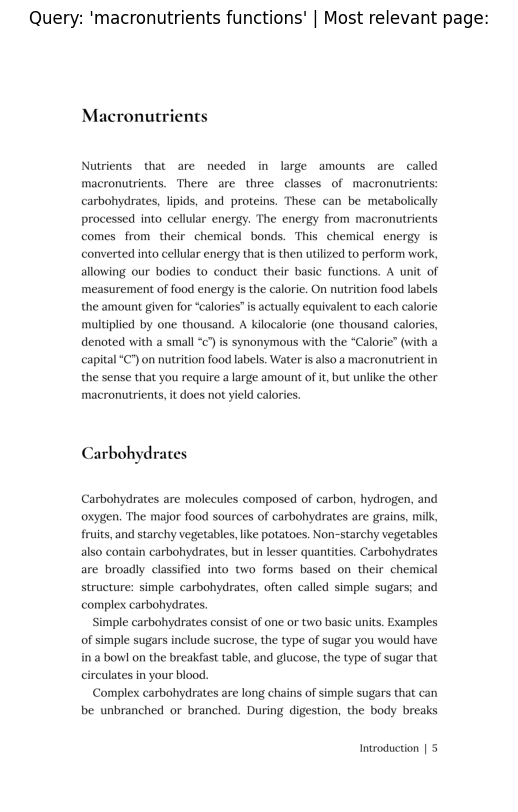

In [118]:
import pymupdf
# Open PDF and load target page

doc = pymupdf.open(pdf_path)
page = doc.load_page(5 + 41)  # number of page (our doc starts page numbers on page 41)

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Optional: save the image
# img.save("output_filename.png")
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv, dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis("off")  # Turn off axis
plt.show()

In [119]:
def retrieve_relevant_resources(
    query: str,
    embeddings: torch.tensor,
    model: SentenceTransformer = embedding_model,
    n_resources_to_return: int = 5,
    print_time: bool = True,
):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query, convert_to_tensor=True)

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(
            f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds."
        )

    scores, indices = torch.topk(input=dot_scores, k=n_resources_to_return)

    return scores, indices


def print_top_results_and_scores(
    query: str,
    embeddings: torch.tensor,
    pages_and_chunks: list[dict] = pages_and_chunks,
    n_resources_to_return: int = 5,
):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """

    scores, indices = retrieve_relevant_resources(
        query=query, embeddings=embeddings, n_resources_to_return=n_resources_to_return
    )

    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

In [123]:
query = "Vitamin A"

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query, embeddings=embeddings)
scores, indices

# Print out the texts of the top scores
print_top_results_and_scores(query=query, embeddings=embeddings)

[INFO] Time taken to get scores on 1680 embeddings: 0.00131 seconds.
[INFO] Time taken to get scores on 1680 embeddings: 0.00044 seconds.
Query: Vitamin A

Results:
Score: 0.6103
Growth and Development Vitamin A acts similarly to some hormones in that it is
able to change the amount of proteins in cells by interacting with DNA. This is
the primary way that vitamin A affects growth and development. Vitamin A
deficiency in children is linked to growth retardation; however, vitamin A
deficiency is often accompanied by protein malnutrition and iron deficiency,
thereby confounding the investigation of vitamin A’s specific effects on growth
and development. In the fetal stages of life, vitamin A is important for limb,
heart, eye, and ear development and in both deficiency and excess, vitamin A
causes birth defects. Furthermore, both males and females require vitamin A in
the diet to effectively reproduce. Cancer Vitamin A’s role in regulating cell
growth and death, especially in tissues that

In [11]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Gunakan model Gemma versi kecil (1B parameter)
model_id = "google/gemma-3-1b-it"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)

llm_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",  # otomatis ke CUDA jika tersedia
    torch_dtype=torch.float16,        # hemat memori
    low_cpu_mem_usage=True
)

# Verifikasi model berhasil dimuat
print(f"[INFO] Model loaded successfully on device: {llm_model.device}")


[INFO] Model loaded successfully on device: cpu


In [ ]:
# Contoh inferensi
query = "Explain the role of macronutrients in the human body."
inputs = tokenizer(query, return_tensors="pt").to(llm_model.device)

with torch.no_grad():
    outputs = llm_model.generate(
        **inputs,
        max_new_tokens=100,
        do_sample=True,
        temperature=0.7,
        top_k=50,
        top_p=0.9,
        repetition_penalty=1.2,
        pad_token_id=tokenizer.eos_token_id,
    )

# Cetak hasil
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Explain the role of macronutrients in the human body.

**Macronutrient Roles:**

*   **Carbohydrates (45-70%):**
    *   Primary energy source for the body, especially for brain and muscles.
    *   Fueling activity levels, particularly during exercise.
    *   Important for maintaining stable blood sugar levels.

*   **Proteins (10-35%):**
    *   Essential building blocks for tissues like muscle, bones, skin, hair, and nails


In [14]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])


get_model_num_params(llm_model)

999885952

In [15]:
input_text = (
    "What are the macronutrients, and what roles do they play in the human body?"
)
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [{"role": "user", "content": input_text}]

# Apply the chat template
prompt = tokenizer.apply_chat_template(
    conversation=dialogue_template,
    tokenize=False,  # keep as raw text (not tokenized)
    add_generation_prompt=True,
)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
What are the macronutrients, and what roles do they play in the human body?

Prompt (formatted):
<bos><start_of_turn>user
What are the macronutrients, and what roles do they play in the human body?<end_of_turn>
<start_of_turn>model



In [ ]:
%%time
# Tokenize the input text (turn it into numbers) and send it to GPU
input_ids = tokenizer(prompt, return_tensors="pt").to("cpu")
print(f"Model input (tokenized):\n{input_ids}\n")

# Generate outputs passed on the tokenized input
# See generate docs: https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig 
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=500) # define the maximum number of new tokens to create
print(f"Model output (tokens):\n{outputs[0]}\n")

Model input (tokenized):
{'input_ids': tensor([[     2,      2,    105,   2364,    107,   3689,    659,    506, 216955,
         151268, 236764,    532,   1144,  13616,    776,    901,   1441,    528,
            506,   3246,   2742, 236881,    106,    107,    105,   4368,    107]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]])}

Model output (tokens):
tensor([     2,      2,    105,   2364,    107,   3689,    659,    506, 216955,
        151268, 236764,    532,   1144,  13616,    776,    901,   1441,    528,
           506,   3246,   2742, 236881,    106,    107,    105,   4368,    107,
         19058, 236764,   1531, 236789, 236751,   2541,   1679,    506, 216955,
        151268,   1271,  57397, 236764,  12483, 236764,    532,  48377,   1271,
           532,    910,  12763,  13616,    528,    822,   2742, 236761,   5715,
        236858, 236751,    496,   9813,   1385, 236787,    108,   1018, 236770,
        236

In [20]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
What are the macronutrients, and what roles do they play in the human body?<end_of_turn>
<start_of_turn>model
Okay, let's break down the macronutrients – carbohydrates, proteins, and fats – and their vital roles in your body. Here’s a detailed look:

**1. Carbohydrates**

* **What they are:** Carbohydrates are your body’s primary energy source. They are broken down into glucose, which the body uses for fuel.
* **Types:**
    * **Simple Carbohydrates (Sugars):** Found in fruits, honey, table sugar, and processed foods. Provide quick energy, but can cause rapid blood sugar spikes.
    * **Complex Carbohydrates (Starches & Fiber):** Found in whole grains, vegetables, beans, and legumes. Provide sustained energy release and are good for digestive health.
* **Roles in the Body:**
    * **Energy Source:**  The body's main fuel source, particularly for the brain and muscles.
    * **Brain Function:**  Glucose is vital for brain function an

## 5. Prompting


## 6. Answer Generation


In [22]:
import subprocess


def export_requirements(output_file="requirements.txt"):
    try:
        # Jalankan pip freeze dan arahkan outputnya ke file
        with open(output_file, "w") as f:
            subprocess.check_call(["pip", "freeze"], stdout=f)
        print(f"Daftar paket berhasil disimpan ke {output_file}")
    except subprocess.CalledProcessError as e:
        print(f"Gagal mengekspor paket: {e}")


export_requirements()  # akan menyimpan ke requirements.txt

Daftar paket berhasil disimpan ke requirements.txt
